# Results

In [62]:
log_path = 'training_log.txt'

In [63]:
# imports

import re
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
pattern = re.compile(
    r'^(?P<epoch>\d+),(?P<loss>[^,]+),(?P<improvement>[^,]+),\[(?P<diversity>[^\]]+)\],\[(?P<pixel_diff>[^\]]+)\],\[(?P<ssim>[^\]]+)\],(?P<time_min>[^,\n]+)$'
)

labels = ['A', 'B', 'G']
metrics = ['ssim', 'diversity', 'pixel_diff']

rows = []
with open(log_path) as f:
    for line in f:
        line = line.strip()

         # skip header
        if not line or line.startswith('epoch'):
            continue
        m = pattern.match(line)

        if not m:
            continue
        def to_list(s):
            return [float(x.strip()) for x in s.split(',') if x.strip()]
        
        div = to_list(m.group('diversity'))
        pix = to_list(m.group('pixel_diff'))
        ssm = to_list(m.group('ssim'))
        if not (len(div) == len(pix) == len(ssm) == 3):
            continue
        rows.append({
            'epoch': int(m.group('epoch')),
            'diversity_A': div[0], 'diversity_B': div[1], 'diversity_G': div[2],
            'pixel_diff_A': pix[0], 'pixel_diff_B': pix[1], 'pixel_diff_G': pix[2],
            'ssim_A': ssm[0], 'ssim_B': ssm[1], 'ssim_G': ssm[2],
        })

df = pd.DataFrame(rows).sort_values('epoch').reset_index(drop=True)
df.tail(3)

,epoch,diversity_A,diversity_B,diversity_G,pixel_diff_A,pixel_diff_B,pixel_diff_G,ssim_A,ssim_B,ssim_G
57,58,0.0126,0.0104,0.0195,0.0132,0.0159,0.0231,0.8714,0.8819,0.8289
58,59,0.0113,0.0108,0.0200,0.0120,0.0150,0.0239,0.8510,0.8896,0.8162
59,60,0.0135,0.0120,0.0207,0.0130,0.0162,0.0238,0.8734,0.8956,0.8392


In [65]:
# ensure dataframe is in the correct shape

df.shape[0] == 60

True

### Diversity Score Over Ecpochs

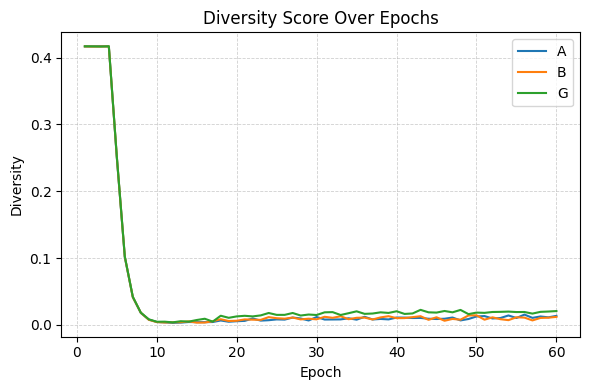

In [66]:
# plot the observations of diversity score

plt.figure(figsize=(6,4))
for lab in labels:
    plt.plot(df['epoch'], df[f'diversity_{lab}'], label=lab)
plt.xlabel('Epoch')
plt.ylabel('Diversity')
plt.title('Diversity Score Over Epochs')
plt.legend()
plt.legend()
plt.grid(linestyle='--', linewidth=0.6, alpha=0.6)
plt.tight_layout()
plt.show()

The above plot shows that the diversity score of the first few epochs were very hight compared to other epochs, this has happened due to the high noise of generted samples from first few epochs. At one point the diversity score has started becoming a lower value and after, started improving it for all the classes. This is beacause the model has haptured the complexity of PET slices upto certain extend within 4 - 10 epochs, and then the model has started learning the patterns inside classes. This is why the the graph looks smoothly improving it's values after 10th epoch. Also, as the y value distance of each graph is considerably low, we can conclude that the model does not suffer any mode collapse issue and the model has likely capture all the modes with likely the same probability.

### Pixel-level Difference Over Epochs

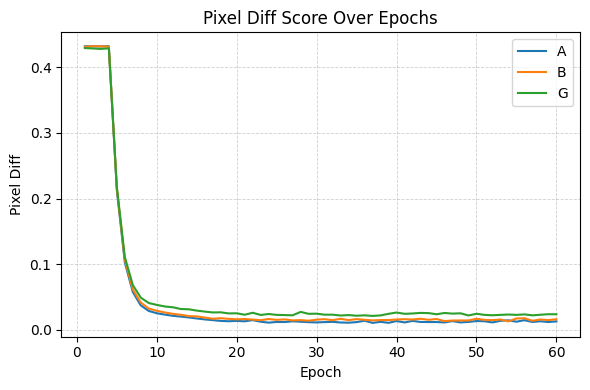

In [67]:
# plot the observations of pixel level difference
plt.figure(figsize=(6,4))
for lab in labels:
    plt.plot(df['epoch'], df[f'pixel_diff_{lab}'], label=lab)
plt.xlabel('Epoch')
plt.ylabel('Pixel Diff')
plt.title('Pixel Diff Score Over Epochs')
plt.legend()
plt.grid(linestyle='--', linewidth=0.6, alpha=0.6)
plt.tight_layout()
plt.show()

The above plot shows that the pixel level difference of the first few epochs were very high compared to other epochs, this has happened due to the high noise of generted samples from first few epochs. At one point the pixel-level differnce started becoming a lower value and after, started improving it for all the classes. This is beacause the model has haptured the complexity of PET slices upto certain extend within 4 - 10 epochs, and then the model has started learning the patterns inside classes. This is why the the graph looks smoothly improving it's values after 10th epoch same as diversity socre. Also, as the y value distance of each graph is considerably low, we can conclude that the model does not suffer any mode collapse issue and the model has likely capture all the modes with likely the same probability. This seems to be a good value because high pixel-diff indicates that synthetic samples are very noisy. Also, very low values migh indicated the model has memorised all the sampels.

### SSIM Score Over Epochs

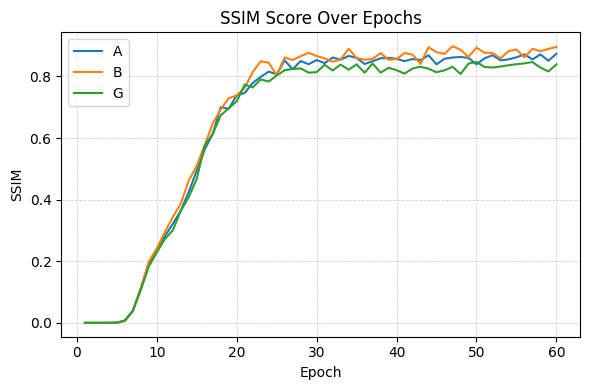

In [68]:
# plot the observations of SSIM score

plt.figure(figsize=(6,4))
for lab in labels:
    plt.plot(df['epoch'], df[f'ssim_{lab}'], label=lab)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('SSIM Score Over Epochs')
plt.legend()
plt.legend()
plt.grid(linestyle='--', linewidth=0.6, alpha=0.6)
plt.tight_layout()
plt.show()

At first, the perceptual similarity of all the classes has very lower values and between 5 -1 0 epochs that has stated improving the value. Lower values indicate there are no perceptual similarity between real sample and generated samples while 1 indicated the perfect perceptual similariy. By looking at the above plot we can conclude that this model has achieved a very good SSIM score for all the classes as it was above 0.8 after 25 epochs. This is a promising performance, with this low resource enviroment setup.

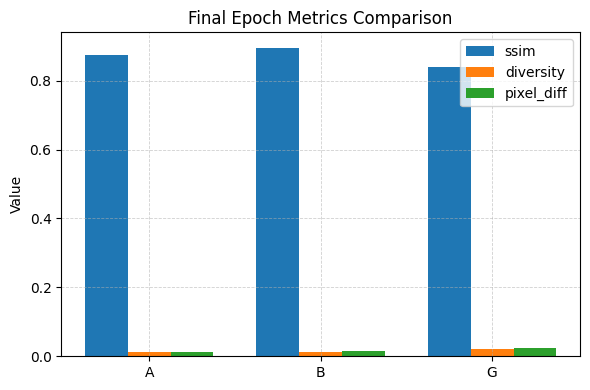

In [69]:
# final epoch comparison

import numpy as np
final = df.iloc[-1]
bar_labels = labels
x = np.arange(len(bar_labels))
width = 0.25

fig, ax = plt.subplots(figsize=(6,4))
for i, metric in enumerate(metrics):
    ax.bar(x + (i-1)*width, [final[f'{metric}_{lab}'] for lab in bar_labels], width, label=metric)

ax.set_xticks(x)
ax.set_xticklabels(bar_labels)
ax.set_ylabel('Value')
ax.set_title('Final Epoch Metrics Comparison')
ax.legend()
plt.legend()
plt.grid(linestyle='--', linewidth=0.6, alpha=0.6)
plt.tight_layout()
plt.show()

/var/folders/y6/v08pgd9n6f32p2hsb0h872_h0000gn/T/ipykernel_4995/758724758.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


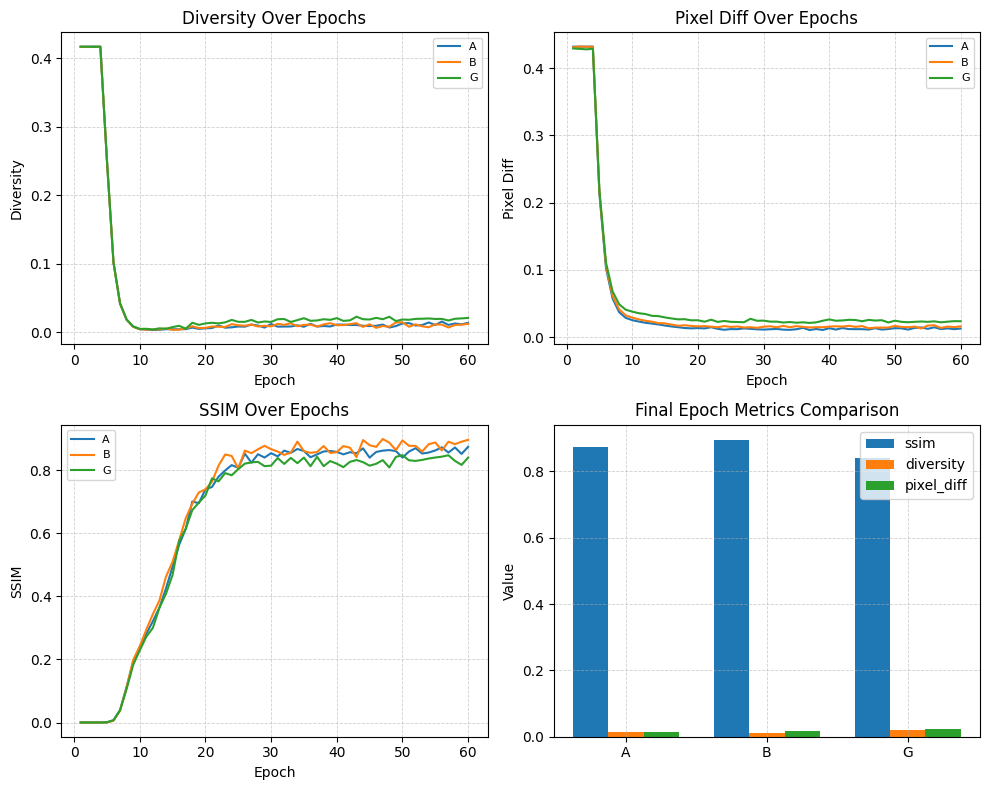

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
(ax_div, ax_pix), (ax_ssim, ax_bar) = axes

# helper to plot a line chart for a metric across epochs for all classes
def plot_metric_lines(ax, metric_key, title, ylabel):
    for lab in labels:
        ax.plot(df['epoch'], df[f'{metric_key}_{lab}'], label=lab)
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    ax.grid(linestyle='--', linewidth=0.6, alpha=0.6)
    ax.legend(fontsize=8)
    plt.legend()

plot_metric_lines(ax_div, 'diversity', 'Diversity Over Epochs', 'Diversity')
plot_metric_lines(ax_pix, 'pixel_diff', 'Pixel Diff Over Epochs', 'Pixel Diff')
plot_metric_lines(ax_ssim, 'ssim', 'SSIM Over Epochs', 'SSIM')


final = df.iloc[-1]
bar_labels = labels
x = np.arange(len(bar_labels))
width = 0.25
for i, metric in enumerate(metrics):
    ax_bar.bar(
        x + (i-1)*width,
        [final[f'{metric}_{lab}'] for lab in bar_labels],
        width,
        label=metric,
        edgecolor='none'
    )

ax_bar.set_xticks(x)
ax_bar.set_xticklabels(bar_labels)
ax_bar.set_ylabel('Value')
ax_bar.set_title('Final Epoch Metrics Comparison')
ax_bar.legend(fontsize=8)
plt.legend()
plt.legend()
plt.grid(linestyle='--', linewidth=0.6, alpha=0.6)
plt.tight_layout()
plt.show()

### Rsults of Final Epoch

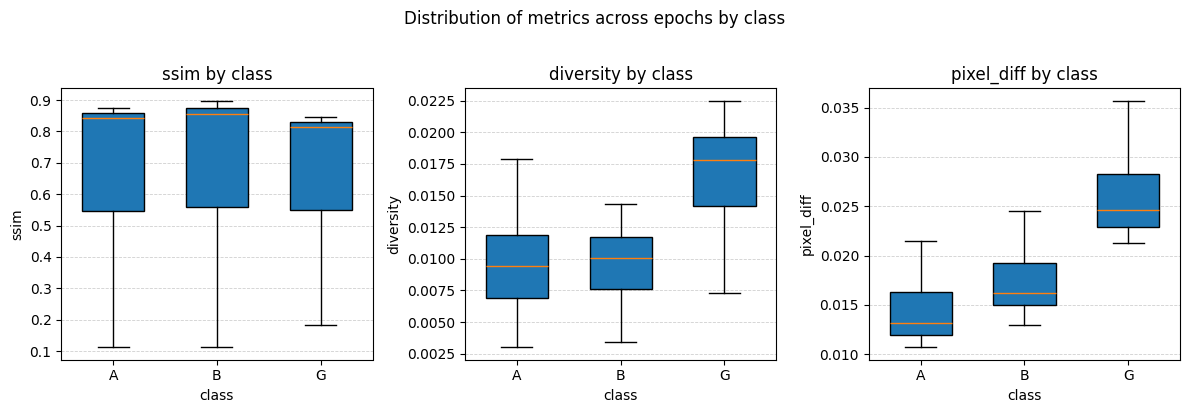

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
for ax, metric in zip(axes, metrics):

    # collect data per class across epochs
    data = [df[f"{metric}_{lab}"].dropna().values for lab in labels]
    bp = ax.boxplot(
        data,
        tick_labels=labels,
        widths=0.6,
        patch_artist=True,
        showfliers=False,

    )
    ax.set_title(f"{metric} by class")
    ax.set_xlabel("class")
    ax.set_ylabel(metric)
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.6)

plt.suptitle("Distribution of metrics across epochs by class", y=1.02)
plt.tight_layout()
plt.show()

Above plots shows the class level ditriution of SSIM, diversitry score and pixel-diff score at epoch 60. 

SSIM - Distribtuions of each class is likely similar
Diversity score - Distributions of first two classes are likely similary but, the model has captured the diveristy of G class compared to other class
Pixel-diff - Values are very smaller, but visually the model has learned the class A better than class B and C. 

Interms of all the metrics, Higher SSIM, Higher Diversity and Low Pixel-diff indicates good results, this is very clear when we look at the class A that had th most samples. Even B had the lowest sample count the metircs showed results better than class G. That is a clear indication of captuing the diversity of rare class without any mode collapse.

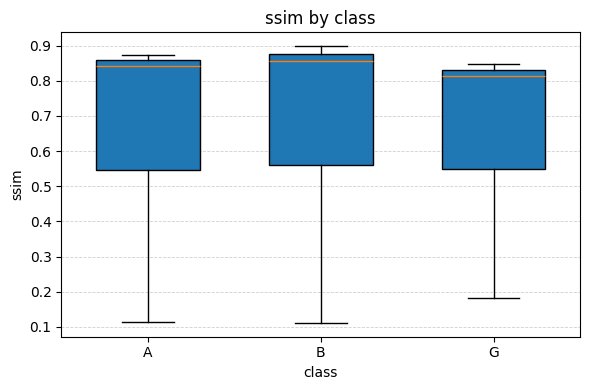

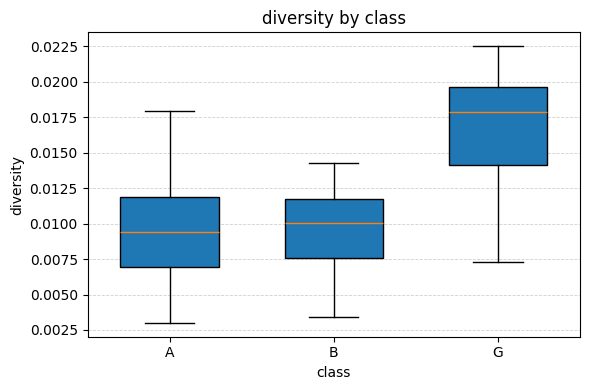

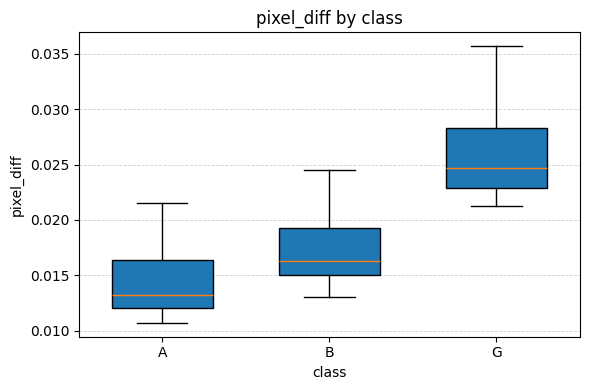

In [74]:
for metric in metrics:
    plt.figure(figsize=(6, 4))
    data = [df[f"{metric}_{lab}"].dropna().values for lab in labels]
    plt.boxplot(
        data,
        tick_labels=labels,
        widths=0.6,
        patch_artist=True,
        showfliers=False,
    )
    plt.title(f"{metric} by class")
    plt.xlabel("class")
    plt.ylabel(metric)
    plt.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.6)
    plt.tight_layout()
    plt.show()